<a href="https://colab.research.google.com/github/dnevo/ImageProcessing/blob/main/ImageProcessingRecitation_06_MedianFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve
import random
random.seed(3)

In [11]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

def read_file(fname:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image
    in a numpy array.

    Args:
        fname: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, fname)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [12]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

# 6. Noise Reduction (S&P)

##6.1 Salt & Pepper Noise - Median filter

In [13]:
def sp_noise(img:np.array, d:float) -> np.array:
    '''
    add 'salt & pepper' noise with density d to an image, imnoise first assigns
    each pixel a random probability value from a standard uniform distribution
    on the open interval (0, 1).
    For pixels with probability value in the range (0, d/2), the pixel value is
      set to 0. The number of pixels that are set to 0 is
      approximately d*numel(I)/2.
    For pixels with probability value in the range [d/2, d), the pixel value is
      set to the maximum value of the image data type. The number of pixels that
      are set to the maximum value is approximately d*numel(I)/2.
    For pixels with probability value in the range [d, 1), the pixel value is
      unchanged.
    Args:
        img: image in float format (range: 0..1)
    Returns:
        img1: in float format (range: 0..1) - s&p noised image
    '''
    img1 = img.copy()
    nrows, ncols = img.shape
    for i in range(nrows):
        for j in range(ncols):
            rdn = random.random()
            if rdn <= d/2:
                img1[i][j] = 0.0
            elif d/2 < rdn < d:
                img1[i][j] = 1.0
            else:
                img1[i][j] = img[i][j]
    return img1

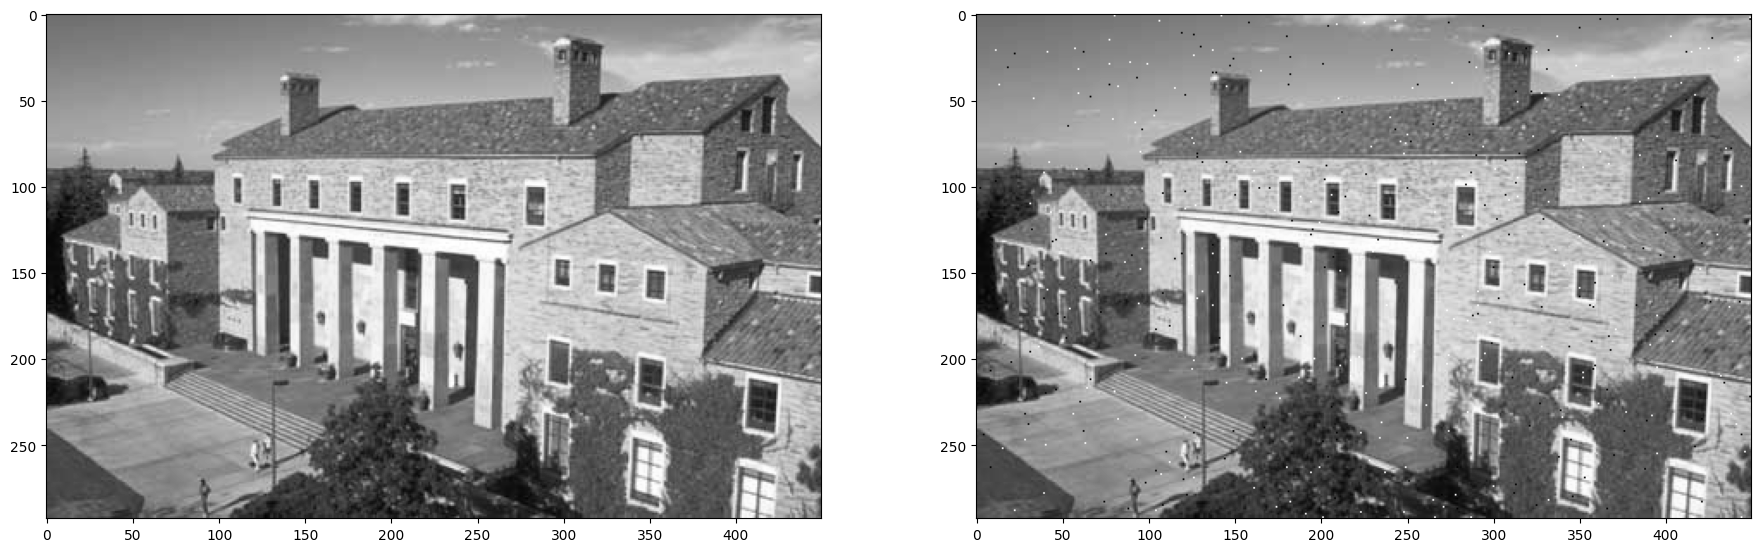

In [14]:
img = read_file(fname='house.tiff') / 255
img1 = sp_noise(img, 0.003)

plot_images(img, img1)

###**Q:** What is the drawback of using a too big median filter (ex: 13x13 instead of 3x3)?

We are risking to loose texture elements like pixels that are intentionaly different from their neighbors.

###Select filter according to the S&P shape

The shaped noise is created using convolution masks:

**Horizontal lines noise:**

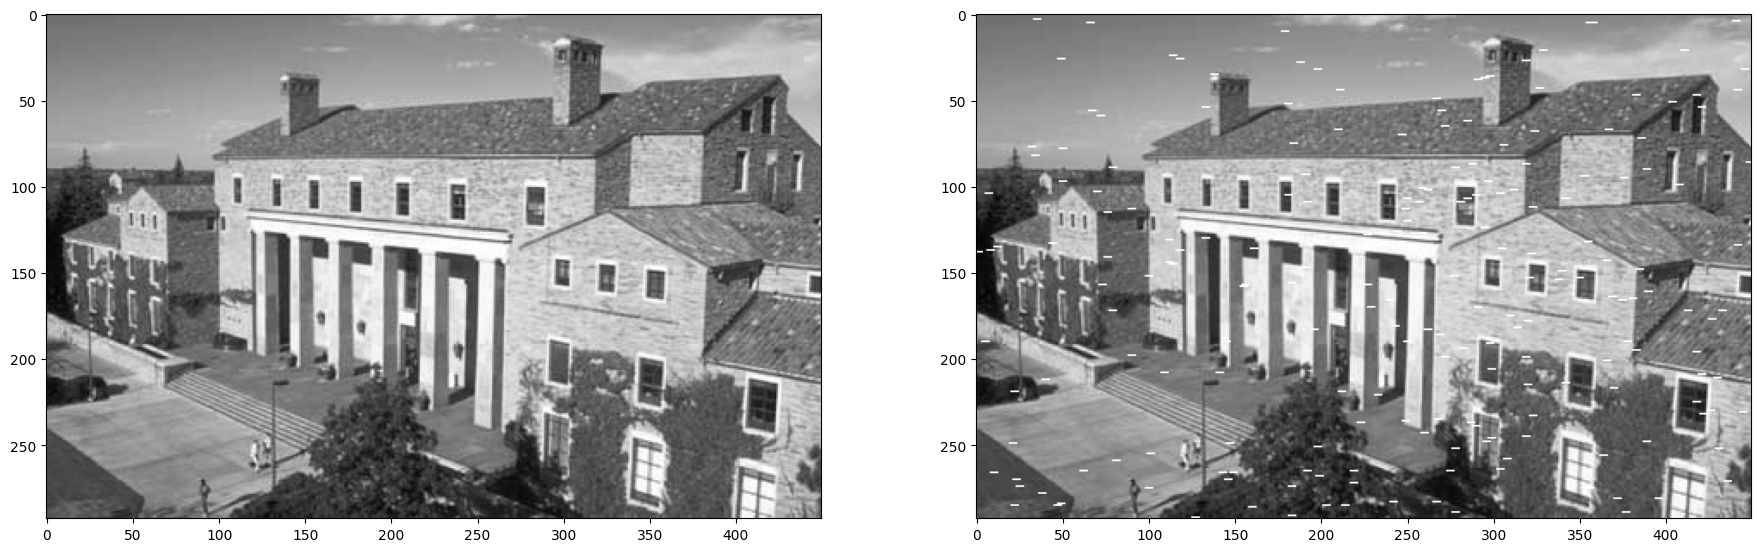

In [15]:
mask = np.zeros(shape=img.shape)
mask = sp_noise(mask, 0.003)
kernel = np.array([[1,1,1,1,1]])
mask = convolve(in1=mask, in2=kernel, mode='same')
mask = np.clip(mask, a_min=0.0, a_max=1.0)
img2 = np.maximum(img, mask)
plot_images(img,img2)

**cross shaped noise:**

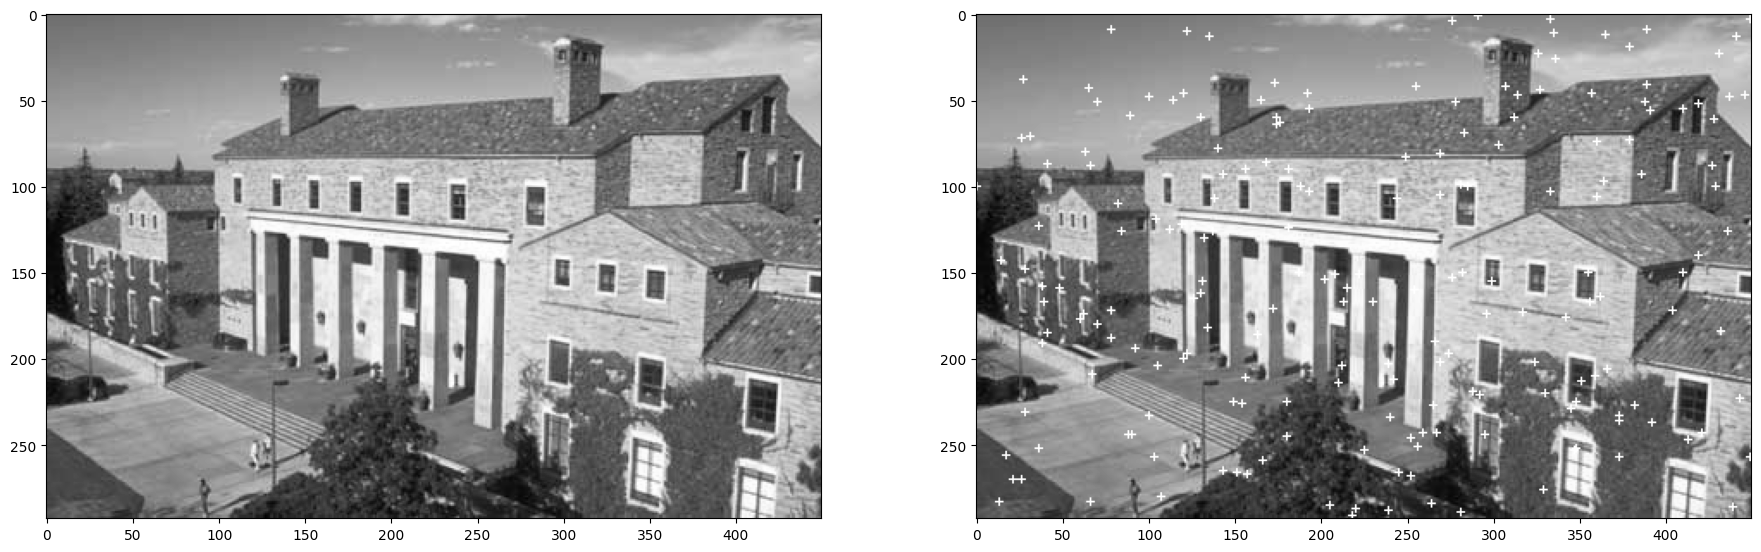

In [16]:
mask = np.zeros(shape=img.shape)
mask = sp_noise(mask, 0.003)
kernel = np.array([[0,0,1,0,0],
                   [0,0,1,0,0],
                   [1,1,1,1,1],
                   [0,0,1,0,0],
                   [0,0,1,0,0]])
mask = convolve(in1=mask, in2=kernel, mode='same')
mask = np.clip(mask, a_min=0.0, a_max=1.0)
img2 = np.maximum(img, mask)
plot_images(img,img2)

**1d Median - no padding**

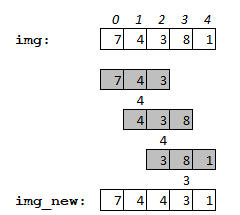

In [17]:
img = np.array([7,4,3,8,1])
new_img = img.copy()
ncols = img.shape[0]
filter_ncols = 3
bcols = filter_ncols // 2
for r in range(bcols, ncols-bcols):
    filter = img[r-bcols:r+bcols+1]
    sort_vec = np.sort(filter, axis=None)
    mid = len(sort_vec) // 2
    print(filter, sort_vec, sort_vec[mid])
    new_img[r] = sort_vec[mid]
print(new_img)

[7 4 3] [3 4 7] 4
[4 3 8] [3 4 8] 4
[3 8 1] [1 3 8] 3
[7 4 4 3 1]


**Notes:**
1. Select filter with odd number of elements (1,3,5,..)
2. Select filter with minimal size (why?)

**1d Median - with padding (Optional)**

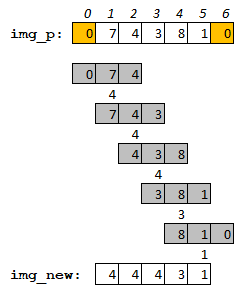